# Task1:RNN预测模拟数据

### 绘制序列

In [95]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import torch.utils.data as Data
import torch.nn.functional as F

In [96]:
# 定义绘制函数
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

### 趋势、噪声的生成函数

In [97]:
# 趋势模式的生成函数
def trend(time, slope=0):
    # 序列和时间成线性关系
    return slope * time

In [98]:
# 噪声模式的生成函数
def white_noise(time, noise_level=1, seed=None):
    # 生成正态分布的伪随机数序列
    rnd = np.random.RandomState(seed)
    # 生成随机数，noise_level为控制噪声幅度大小
    return rnd.randn(len(time)) * noise_level

### 季节性的生成函数

In [99]:
# 季节性模式的生成函数
def seasonal_pattern(season_time):
    # np.where(condition, x, y) 满足条件(condition)，输出x，不满足输出y
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# 将某个季节性模式进行重复
def seasonality(time, period, amplitude=1, phase=0):
    # 将时间映射到0-1之间
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

### 生成混合模式的时序数据

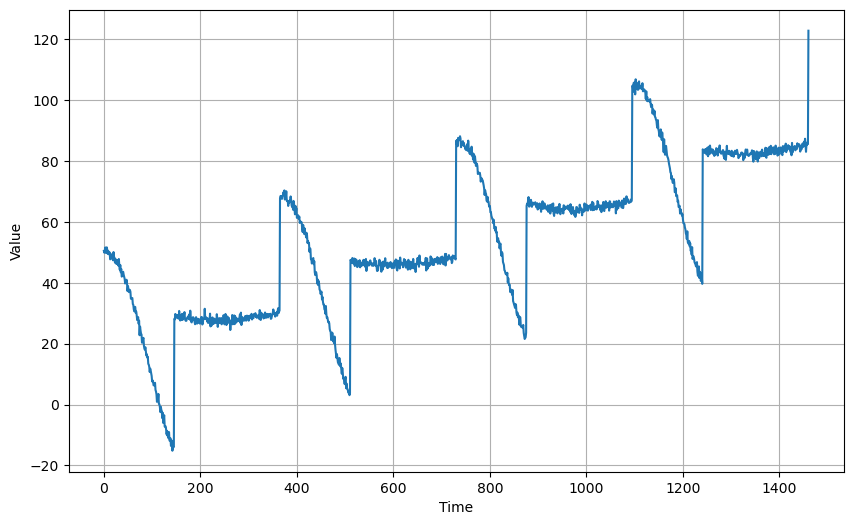

In [100]:
# 生成序列并绘制图像
time = np.arange(4 * 365 + 1)
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 1
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### 参数设置

In [101]:
# 设置超参数
input_size = 1
hidden_size = 256
output_size = 1
epochs = 200
lr = 0.03
batch_size = 128
time_step = 5 # 输入的时间窗口大小

### 数据预处理

In [102]:
# 训练集比例
split_prop = 0.7
train_data = series[:int(len(series)*split_prop)]
test_data = series[int(len(series)*split_prop):]

# 数据归一化
train_data_normalized = (train_data - train_data.min()) / (train_data.max() - train_data.min())
test_data_normalized = (test_data - train_data.min()) / (train_data.max() - train_data.min())

### 滑动窗口采样

In [103]:
train_x, train_y, test_x, test_y = [], [], [], []
# 对训练数据采样
i = 0
while(i + time_step + output_size < len(train_data_normalized)):
    train_x.append(train_data_normalized[i:i+time_step])
    train_y.append(train_data_normalized[i+time_step:i+time_step+output_size])
    i += output_size

# 对测试数据采样
j = 0
while(j + time_step + output_size < len(test_data_normalized)):
    test_x.append(test_data_normalized[j:j+time_step])
    test_y.append(test_data_normalized[j+time_step:j+time_step+output_size])
    j += output_size

### 装入数据

In [104]:
# 转为 tensor
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# 装入 dataloader
train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### 构建 RNN 网络

In [105]:
# 设置默认张量类型为 Float
torch.set_default_tensor_type(torch.FloatTensor)

In [106]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_step):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.time_step = time_step

        # 创建 RNN 层和 linear 层，RNN 提取特征，linear 进行预测
        self.rnn = nn.RNN(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers=1, 
            batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # RNN 层
        r_out, _ = self.rnn(x)
        # 按照RNN 模型结构修改 input_seq的形状，作为 linear 层的输入
        r_out = r_out.reshape(-1, self.hidden_size)    
        out = self.out(r_out)
        # 将 out恢复成（batch_size, seq_len, output_size）的形状
        out = out.reshape(-1, self.time_step, self.output_size)
        return out[:, -1, :]

### 模型参数初始化

In [107]:
# 实例化神经网络
net = MyRNN(input_size, hidden_size, output_size, time_step)
# 初始化网络参数
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)
# 设置损失函数
loss = nn.MSELoss()
# 设置优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# GPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
net.to(device)

MyRNN(
  (rnn): RNN(1, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

### 开始训练

In [108]:
train_x.shape

torch.Size([1016, 5])

In [109]:
train_x

tensor([[0.6354, 0.6296, 0.6376, 0.6462, 0.6293],
        [0.6296, 0.6376, 0.6462, 0.6293, 0.6293],
        [0.6376, 0.6462, 0.6293, 0.6293, 0.6467],
        ...,
        [0.7647, 0.7884, 0.7737, 0.7656, 0.7674],
        [0.7884, 0.7737, 0.7656, 0.7674, 0.7692],
        [0.7737, 0.7656, 0.7674, 0.7692, 0.7766]])

In [110]:
def train(net, epochs, train_loader, test_x, test_y):
    train_loss, test_loss = [], []
    for epoch in range(epochs):
        train_l, test_l = [], 0
        for x,y in train_loader:
            # RNN 输入数据的形状为 (seq_len, batch, input_size),于是将 x 转为三维
            x = torch.unsqueeze(x, dim=2)
            # GPU
            x, y = x.to(device), y.to(device)
            # 预测
            y_predict = net(x)
            # 计算 loss
            l = loss(y_predict, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l.append(l.item())
        # 修改测试集的维度
        test_x_temp = torch.unsqueeze(test_x, dim=2)
        # GPU
        test_x_temp = test_x_temp.to(device) 
        test_y_temp = test_y.to(device)
        # 测试集的预测
        test_predict = net(test_x_temp)
        # 计算测试集的 loss
        test_l = loss(test_predict, test_y_temp)
        # 打印输出
        print('epoch %d, train_loss %.5f, test_loss %.5f' % (epoch+1, np.array(train_l).mean(), test_l.item()))

        train_loss.append(np.array(train_l).mean())
        test_loss.append(test_l.item())
    return train_loss, test_loss

In [111]:
train_loss, test_loss = train(net, epochs, train_loader, test_x, test_y)

epoch 1, train_loss 0.24433, test_loss 0.45845
epoch 2, train_loss 0.10297, test_loss 0.28499
epoch 3, train_loss 0.05692, test_loss 0.20477
epoch 4, train_loss 0.04249, test_loss 0.16645
epoch 5, train_loss 0.03821, test_loss 0.14744
epoch 6, train_loss 0.03690, test_loss 0.13655
epoch 7, train_loss 0.03647, test_loss 0.13026
epoch 8, train_loss 0.03623, test_loss 0.12754
epoch 9, train_loss 0.03608, test_loss 0.12670
epoch 10, train_loss 0.03596, test_loss 0.12528
epoch 11, train_loss 0.03575, test_loss 0.12505
epoch 12, train_loss 0.03563, test_loss 0.12331
epoch 13, train_loss 0.03546, test_loss 0.12249
epoch 14, train_loss 0.03533, test_loss 0.12242
epoch 15, train_loss 0.03521, test_loss 0.12262
epoch 16, train_loss 0.03498, test_loss 0.12215
epoch 17, train_loss 0.03484, test_loss 0.12141
epoch 18, train_loss 0.03470, test_loss 0.12103
epoch 19, train_loss 0.03443, test_loss 0.11934
epoch 20, train_loss 0.03436, test_loss 0.11937
epoch 21, train_loss 0.03411, test_loss 0.11803
e

### 绘制 loss 曲线

In [112]:
def plot_loss(train_loss, test_loss):
    plt.plot(range(epochs), train_loss, label='train_loss')
    plt.plot(range(epochs), test_loss, label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

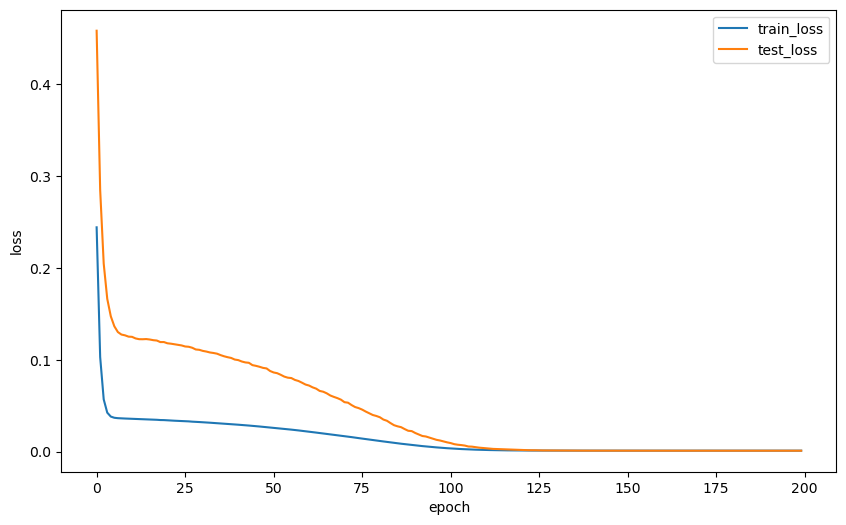

In [113]:
plot_loss(train_loss, test_loss)

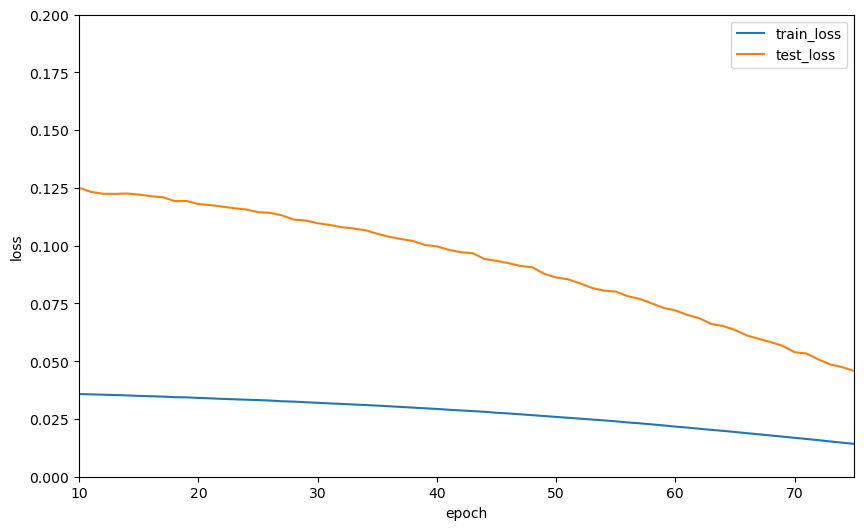

In [114]:
# 绘制局部 loss
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.xlim(10, 75)
plt.ylim(0, 0.2)
plt.show()

### 预测并与真实值对比

In [115]:
test_x_temp = torch.unsqueeze(test_x, dim=2)
test_x_temp = test_x_temp.to(device)
predict = net(test_x_temp)
# 逆归一化
predict = predict.cpu().detach().numpy() * (train_data.max() - train_data.min()) + train_data.min()
test_y = np.array(test_y) * (train_data.max() - train_data.min()) + train_data.min()
# 将数据从[[output_size]]转为[x1, x2, x3, ...]
predict_result = []
test_y_result = []
for item in predict:
    predict_result += item.tolist()
for item in test_y:
    test_y_result += item.tolist()

### 预测并与真实值对比

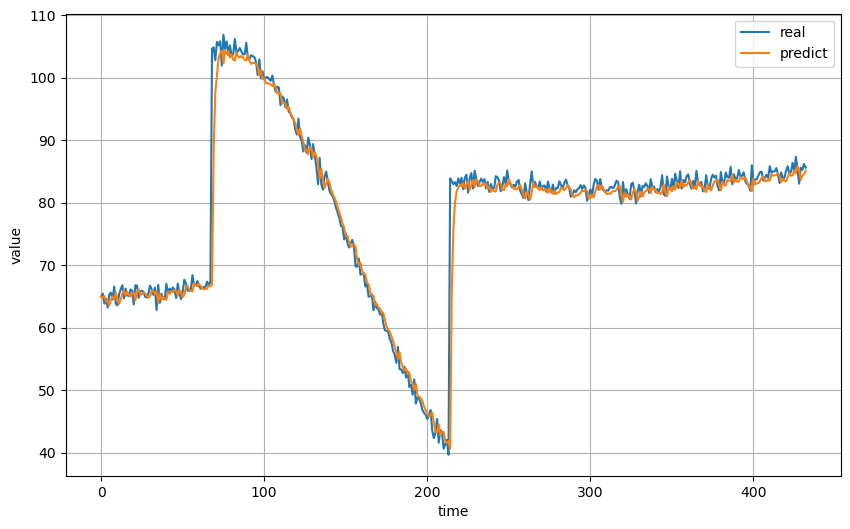

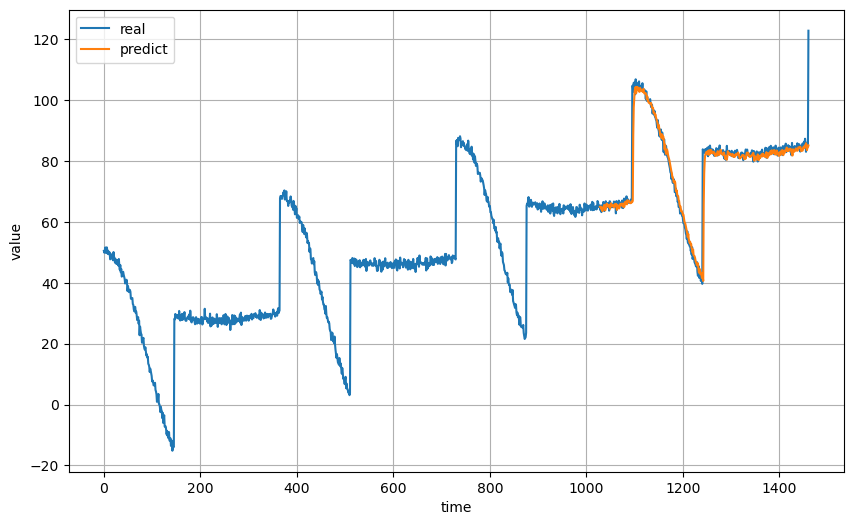

In [116]:
# 指定figure的宽和高
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
# 画出实际和预测的对比图
plt.plot(range(len(test_y_result)), test_y_result, label='real')
plt.plot(range(len(predict_result)), predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()
# 与整体数据进行比较
plt.plot(range(len(series)), series, label='real')
plt.plot(range(len(series)-len(predict_result), len(series)), predict_result, label='predict')
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()